# Segmentation: MRCNN(MASK RCNN)


- yolo보다는 느림
> faster RCNN 기반
>> RPN:  region proposal network 
- 특정 부분이나 피처 맵에 어떤 오브젝트가 있는지를 예측하는 모델

>>ROI(Region of Interest)
- RPN을 기반으로 얻은 box가 다른 모양일 때
- poooling레이어를 사용하여 모든 영ㅇ역과 동일한 모양으로 변환

>>IOU
- 교점 면적 / 연합 면접
- Iou가 0.5(threshold)보다 큰 지역만 선택
- box가 여러개 있을 때 중첩되는 부분남 선택

>> Segmentation  mask
- IoU값을 기반으로 ROI를 확보-> mask적용
- 객체가 포함된 영여게 대한 마스크 반환


> coco dataset
- class ID
- bounding box
- segmentation
- 위의 세가지 정보가 모두 갖고 있음.

In [22]:
# https://github.com/matterport/Mask_RCNN    
import cv2 as cv2
import argparse
import numpy as np
import os.path
import sys
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

In [24]:
# Draw the predicted bounding box, colorize and show the mask on the image

def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    # mask: 15*15-> 실제 검출된 객체 크기 만큼 resize
    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    # 원본 영상에서 현재 검출된 부분(mask)에 해당하는 부분만 갖고오기
    roi = frame[top:bottom+1, left:right+1][mask]

    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]                 # mask 가중치    
    # 원본 영상과 mask영상을 섞기(원본 영상의 픽셀(0.3)과 semantation픽셀(0.7)을 서로 갖고오기)
    # alpha blending
    # for문 사용하지 않는 trick 사용 
    frame[top:bottom+1, left:right+1][mask] = \
    ([0.7*color[0], 0.7*color[1], 0.7*color[2]] + 0.3 * roi).astype(np.uint8)

    

In [9]:
def postprocess(boxes, masks):
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]  # 7개 정보  ?, classid, score, left, top 
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]

            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)

In [10]:
# 90개 사용 , 빈 class가 있어서 실제로는 80개 class
classesFile = "./models/mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# 그래프 구조
textGraph = "./models/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
# weight 파일
modelWeights = "./models/frozen_inference_graph.pb"   # 다운받아야 함

# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "./models/colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float
                      (rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)

## 1.1. 자동차 예제

In [16]:
frame = cv2.imread('./images/cars.jpg')

# 꼭 쓰지 않아도 numpy객체로 만들어서 써도 됨. scaling하지 않고 사용
blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)

# input
net.setInput(blob)

# boxes - 검출에 관련된 결과
# masks:segmantation 결과 -> 2개가 서로 연관되지 않음
# mask크기: 무조건 15 * 15
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

### boxes(100개 찾음)

In [19]:
print(boxes.shape)   # 1,1,100box,7개 정보(?, classid, score, left, top )

print(boxes[0,0,5])  # 5번째 box
id = int(boxes[0,0,5,1])
print('id',id)

(1, 1, 100, 7)
(100, 90, 15, 15)
[0.         2.         0.81254685 0.44311842 0.78289765 0.64019954
 1.        ]
id 2


### mask(15 * 15)

(100, 90, 15, 15)
m.shape: (15, 15)


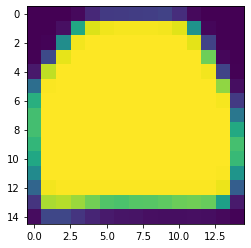

In [21]:
# mask shape: 15 * 15로 고정 -> network 결과 항상 동일한 값임.
print(masks.shape)   # 100개box, 90개클래스, mask

m = masks[0,id, :,:]
print('m.shape:',m.shape)
plt.imshow(m)

In [11]:
postprocess(boxes, masks)

t, _ = net.getPerfProfile()
label = 'Mask-RCNN, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

array([[[241, 232, 219],
        [241, 232, 219],
        [241, 232, 219],
        ...,
        [108, 143, 147],
        [102, 137, 141],
        [ 98, 133, 137]],

       [[241, 232, 219],
        [241, 232, 219],
        [241, 232, 219],
        ...,
        [ 98, 130, 135],
        [ 91, 123, 128],
        [ 87, 119, 124]],

       [[241, 232, 219],
        [241, 232, 219],
        [241, 232, 219],
        ...,
        [ 79, 109, 114],
        [ 71, 100, 105],
        [ 68,  97, 102]],

       ...,

       [[ 77,  89,  99],
        [ 77,  89,  99],
        [ 75,  90,  99],
        ...,
        [ 97,  93,  98],
        [ 97,  93,  98],
        [ 97,  93,  98]],

       [[ 79,  91, 101],
        [ 78,  90, 100],
        [ 76,  91, 100],
        ...,
        [ 96,  92,  97],
        [ 97,  93,  98],
        [ 97,  93,  98]],

       [[ 80,  92, 102],
        [ 79,  91, 101],
        [ 76,  91, 100],
        ...,
        [ 96,  92,  97],
        [ 96,  92,  97],
        [ 97,  93,  98]]

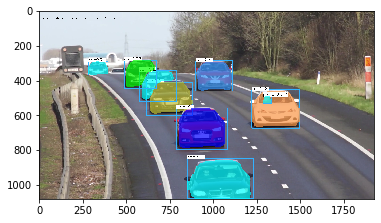

In [12]:
cv2.imwrite("./images/seg_output.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 1.2. 강아지 사진

In [24]:
frame = cv2.imread('./images/dog.jpg')

# 꼭 쓰지 않아도 numpy객체로 만들어서 써도 됨. scaling하지 않고 사용
blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)

# input
net.setInput(blob)

# boxes - 검출에 관련된 결과
# masks:segmantation 결과 -> 2개가 서로 연관되지 않음
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

postprocess(boxes, masks)

t, _ = net.getPerfProfile()
label = 'Mask-RCNN, Inference time for a frame : %0.0f ms' % abs(t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

array([[[245, 250, 253],
        [242, 247, 250],
        [250, 255, 255],
        ...,
        [249, 254, 253],
        [249, 254, 253],
        [249, 254, 253]],

       [[249, 252, 255],
        [245, 250, 251],
        [248, 253, 254],
        ...,
        [249, 254, 253],
        [249, 254, 253],
        [249, 254, 253]],

       [[251, 255, 255],
        [248, 252, 253],
        [244, 252, 252],
        ...,
        [247, 253, 252],
        [248, 254, 253],
        [248, 254, 253]],

       ...,

       [[244, 253, 255],
        [244, 253, 255],
        [246, 253, 255],
        ...,
        [241, 255, 254],
        [244, 254, 254],
        [247, 255, 255]],

       [[245, 254, 255],
        [245, 254, 255],
        [246, 253, 255],
        ...,
        [244, 254, 254],
        [249, 254, 255],
        [250, 254, 255]],

       [[246, 255, 255],
        [245, 254, 255],
        [246, 253, 255],
        ...,
        [247, 255, 255],
        [250, 254, 255],
        [251, 253, 254]]

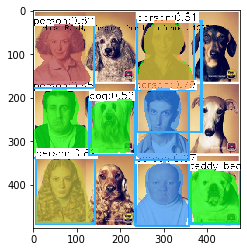

In [25]:
cv2.imwrite("./images/seg_dog.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)